In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gdp-per-capita-2010-2019/filtered_gdp_per_capita (2).csv
/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


# Import Libraries and Data

In [2]:
import pandas as pd
import numpy as np
import dateutil.easter as easter
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
import math
import warnings

warnings.filterwarnings(action="ignore")
sns.set(style="whitegrid")

In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')
gdp = pd.read_csv('/kaggle/input/gdp-per-capita-2010-2019/filtered_gdp_per_capita (2).csv')

for df in [train_df, test_df]:
    df['date'] = pd.to_datetime(df.date)
    df.set_index('date', inplace=True, drop=False)

In [4]:
display(train_df.head())
display(test_df.head())
display(gdp.head())

,id,date,country,store,product,num_sold
date,,,,,,
2010-01-01,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
2010-01-01,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2010-01-01,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
2010-01-01,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
2010-01-01,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


,id,date,country,store,product
date,,,,,
2017-01-01,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
2017-01-01,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2017-01-01,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
2017-01-01,230133,2017-01-01,Canada,Discount Stickers,Kerneler
2017-01-01,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


,year,GDP_Canada,GDP_Finland,GDP_Italy,GDP_Kenya,GDP_Norway,GDP_Singapore
0,2010,47562.083425,46459.973255,36000.520118,1080.296184,87693.790066,47236.960235
1,2011,52223.696112,51081.997670,38599.062207,1085.487152,100600.562408,53890.428727
2,2012,52669.089963,47710.790217,35053.526244,1271.815383,101524.141852,55546.488539
3,2013,52635.174958,49878.043244,35549.974697,1354.820833,102913.450844,56967.425794
4,2014,50955.998323,50260.299859,35518.415292,1462.220052,97019.182753,57562.530794


In [5]:
train_df['missing_num_sold'] = train_df['num_sold'].isnull()

train_df.head()

,id,date,country,store,product,num_sold,missing_num_sold
date,,,,,,,
2010-01-01,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,True
2010-01-01,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,False
2010-01-01,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,False
2010-01-01,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,False
2010-01-01,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,False


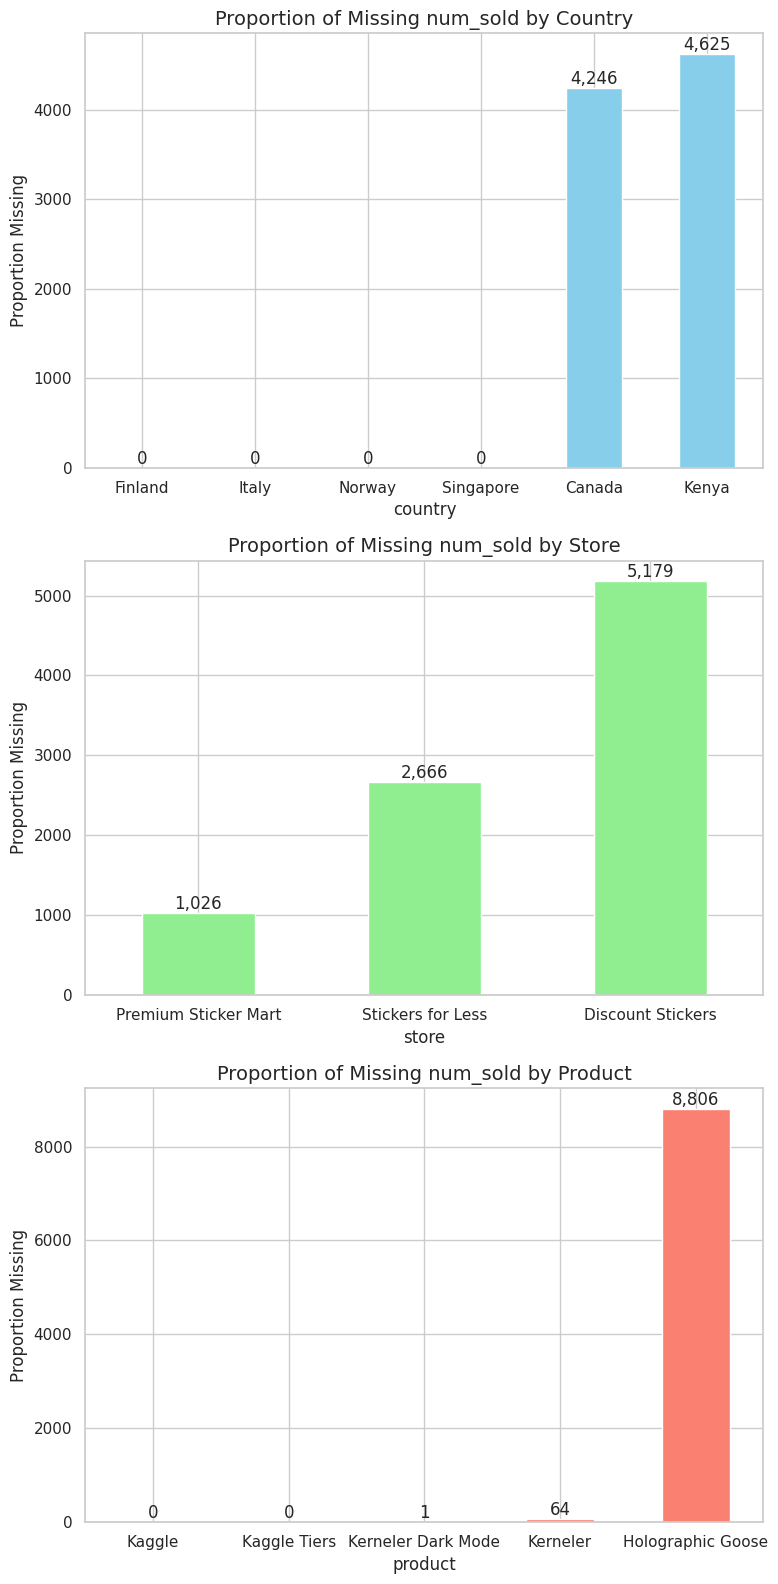

In [6]:
missing_by_country = train_df.groupby('country')['missing_num_sold'].sum()
missing_by_store = train_df.groupby('store')['missing_num_sold'].sum()
missing_by_product = train_df.groupby('product')['missing_num_sold'].sum()

fig, axes = plt.subplots(3, 1, figsize=(8, 16), sharex=False)

def annotate_bars(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():,.0f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom')

# Missingness by country
ax0 = missing_by_country.sort_values().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Proportion of Missing num_sold by Country', fontsize=14)
axes[0].set_ylabel('Proportion Missing')
annotate_bars(axes[0])
axes[0].tick_params(axis='x', rotation=0)

# Missingness by store
ax1 = missing_by_store.sort_values().plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Proportion of Missing num_sold by Store', fontsize=14)
axes[1].set_ylabel('Proportion Missing')
annotate_bars(axes[1])
axes[1].tick_params(axis='x', rotation=0)

# Missingness by product
ax2 = missing_by_product.sort_values().plot(kind='bar', ax=axes[2], color='salmon')
axes[2].set_title('Proportion of Missing num_sold by Product', fontsize=14)
axes[2].set_ylabel('Proportion Missing')
annotate_bars(axes[2])
axes[2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('missing.png')  
plt.show()
plt.close()

### Key Observations:
* Missing data is NOT random: Concentrated in specific categories.
* By Country: Canada and Kenya have substantial missing data.
* By Store: Discount Stickers has the most missing data.
* By Product: Holographic Goose has a very high proportion of missing data.
* Missingness is non-random, indicating potential data collection/recording issues, especially for Holographic Goose and Discount Stickers.

In [7]:
train_df['num_sold'].fillna(0, inplace=True)
train_df.isnull().sum()

id                  0
date                0
country             0
store               0
product             0
num_sold            0
missing_num_sold    0
dtype: int64

# EDA

In [8]:
print("Train Dataset:\nFirst day:", train_df.date.min(), "   Last day:", train_df.date.max())
print("Test Dataset:\nFirst day:", test_df.date.min(), "   Last day:", test_df.date.max())

Train Dataset:
First day: 2010-01-01 00:00:00    Last day: 2016-12-31 00:00:00
Test Dataset:
First day: 2017-01-01 00:00:00    Last day: 2019-12-31 00:00:00


In [9]:
# Extract seasonal attributes
train_df['day'] = train_df['date'].dt.day
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['quarter'] = train_df['date'].dt.quarter
train_df['weekday'] = train_df['date'].dt.weekday 

### Sales by Country

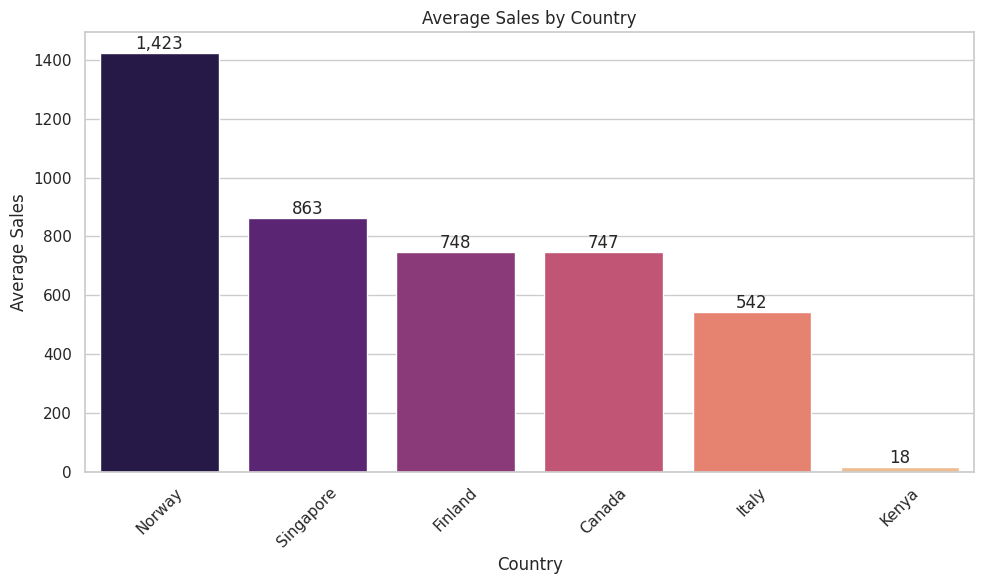

In [10]:
country_sales = train_df.groupby('country')['num_sold'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=country_sales.index, y=country_sales.values, palette='magma')
plt.title("Average Sales by Country")
plt.xlabel("Country")
plt.ylabel("Average Sales")

for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sales and GDP per Capita Correlation

In [11]:
yearly_sales = train_df.groupby(['year', 'country'])['num_sold'].sum().reset_index()
gdp_long = gdp.melt(id_vars='year', var_name='country', value_name='GDP_per_capita')
gdp_long['country'] = gdp_long['country'].str.replace('GDP_', '')
gdp_sales = pd.merge(yearly_sales, gdp_long, on=['year', 'country'], how='inner')

In [12]:
display(yearly_sales.head())
display(gdp_long.head())
display(gdp_sales.head())

,year,country,num_sold
0,2010,Canada,3860459.0
1,2010,Finland,3899688.0
2,2010,Italy,3009216.0
3,2010,Kenya,74259.0
4,2010,Norway,7334357.0


,year,country,GDP_per_capita
0,2010,Canada,47562.083425
1,2011,Canada,52223.696112
2,2012,Canada,52669.089963
3,2013,Canada,52635.174958
4,2014,Canada,50955.998323


,year,country,num_sold,GDP_per_capita
0,2010,Canada,3860459.0,47562.083425
1,2010,Finland,3899688.0,46459.973255
2,2010,Italy,3009216.0,36000.520118
3,2010,Kenya,74259.0,1080.296184
4,2010,Norway,7334357.0,87693.790066


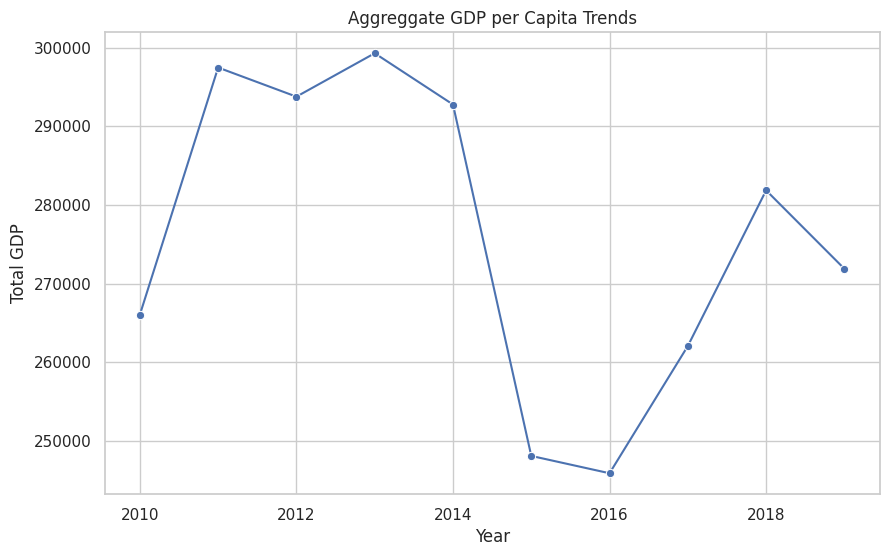

In [13]:
agg_gdp=gdp_long.groupby('year')['GDP_per_capita'].sum()

plt.figure(figsize=(10, 6))
sns.lineplot(x=agg_gdp.index, y=agg_gdp.values, marker='o', color='b')
plt.title('Aggreggate GDP per Capita Trends')
plt.xlabel('Year')
plt.ylabel('Total GDP')
plt.grid(True)
plt.show()

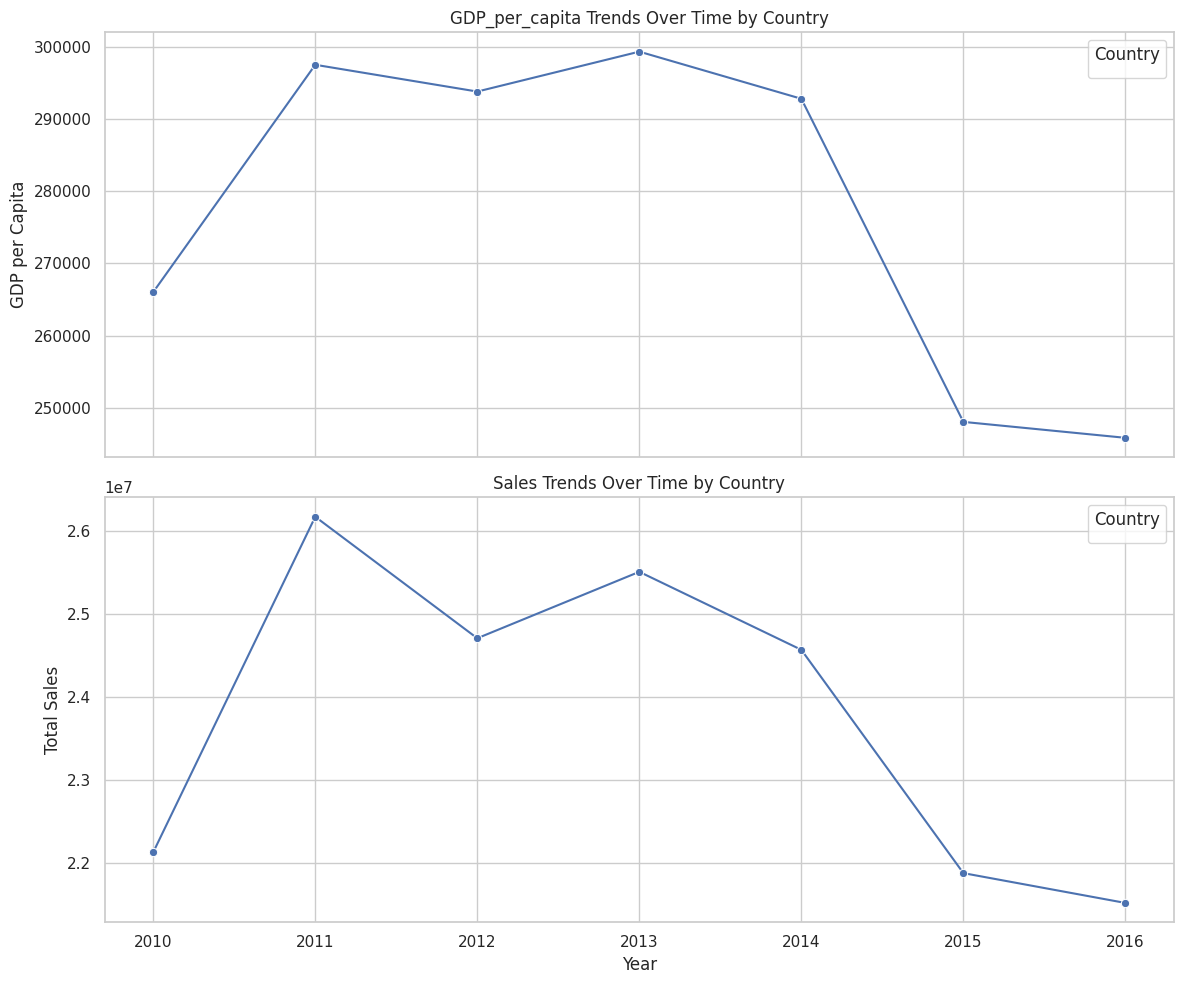

In [14]:
agg_gdp=gdp_sales.groupby('year')['GDP_per_capita'].sum()
yearly_sales = gdp_sales.groupby('year')['num_sold'].sum()

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

sns.lineplot(x=agg_gdp.index, y=agg_gdp.values, marker='o', color='b', ax=axes[0])
axes[0].set_title("GDP_per_capita Trends Over Time by Country")
axes[0].set_ylabel("GDP per Capita")
axes[0].legend(title="Country")

sns.lineplot(x=yearly_sales.index, y=yearly_sales.values, marker='o', color='b', ax=axes[1])
axes[1].set_title("Sales Trends Over Time by Country")
axes[1].set_ylabel("Total Sales")
axes[1].set_xlabel("Year")
axes[1].legend(title="Country")

plt.tight_layout()
plt.show()

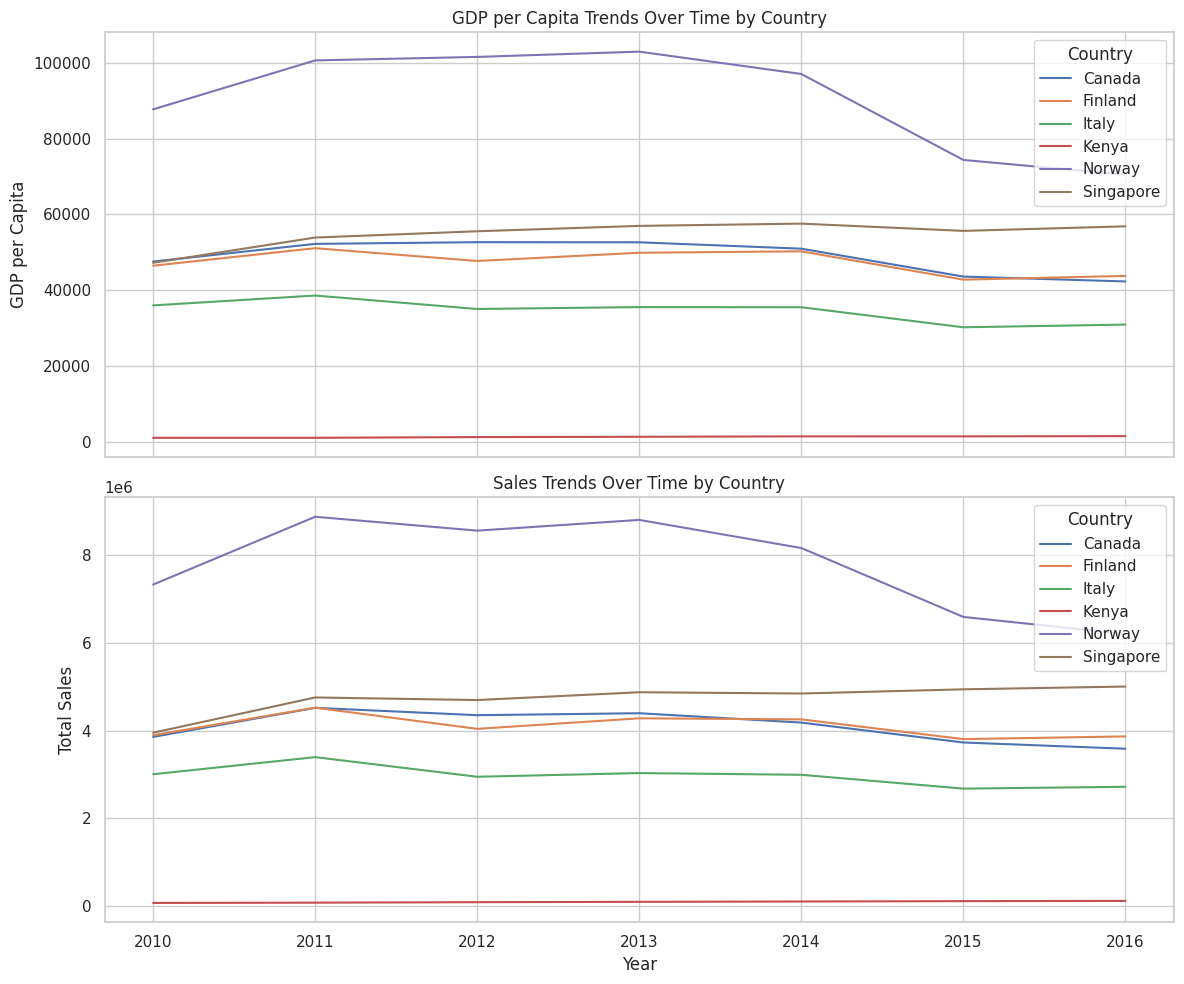

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

sns.lineplot(data=gdp_sales, x="year", y="GDP_per_capita", hue="country", ax=axes[0])
axes[0].set_title("GDP per Capita Trends Over Time by Country")
axes[0].set_ylabel("GDP per Capita")
axes[0].legend(title="Country")

sns.lineplot(data=gdp_sales, x="year", y="num_sold", hue="country", ax=axes[1])
axes[1].set_title("Sales Trends Over Time by Country")
axes[1].set_ylabel("Total Sales")
axes[1].set_xlabel("Year")
axes[1].legend(title="Country")

plt.tight_layout()
plt.savefig('gdp_and_sales.png')  
plt.show() 
plt.close()

#### Key Observations:
* A potential positive correlation exists between GDP per capita and total sales.
* Countries with higher GDP (e.g., Norway, Singapore) generally had higher sales.

In [16]:
y = gdp_sales['GDP_per_capita']
x = gdp_sales['num_sold']
correlation = y.corr(x)
correlation 

0.9988387417222673

Correlation between GDP per Capita and num_sold:
0.9988387417222673


Text(0, 0.5, 'num_sold')

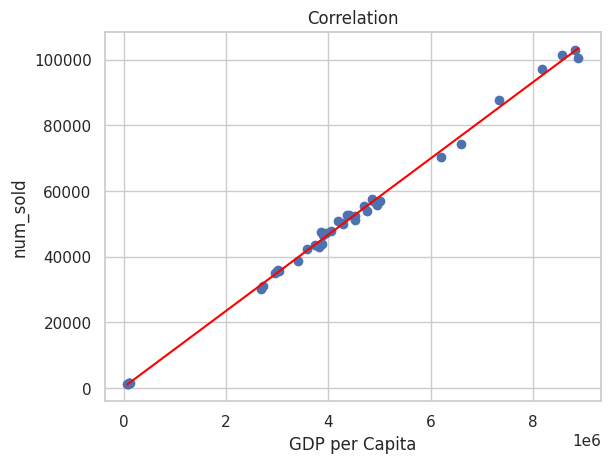

In [17]:
y = gdp_sales['GDP_per_capita']
x = gdp_sales['num_sold']
correlation = y.corr(x)
print(f'Correlation between GDP per Capita and num_sold:\n{correlation}')

plt.title('Correlation')
plt.scatter(x, y)
plt.plot(np.unique(x), 
         np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')

plt.xlabel('GDP per Capita')
plt.ylabel('num_sold')

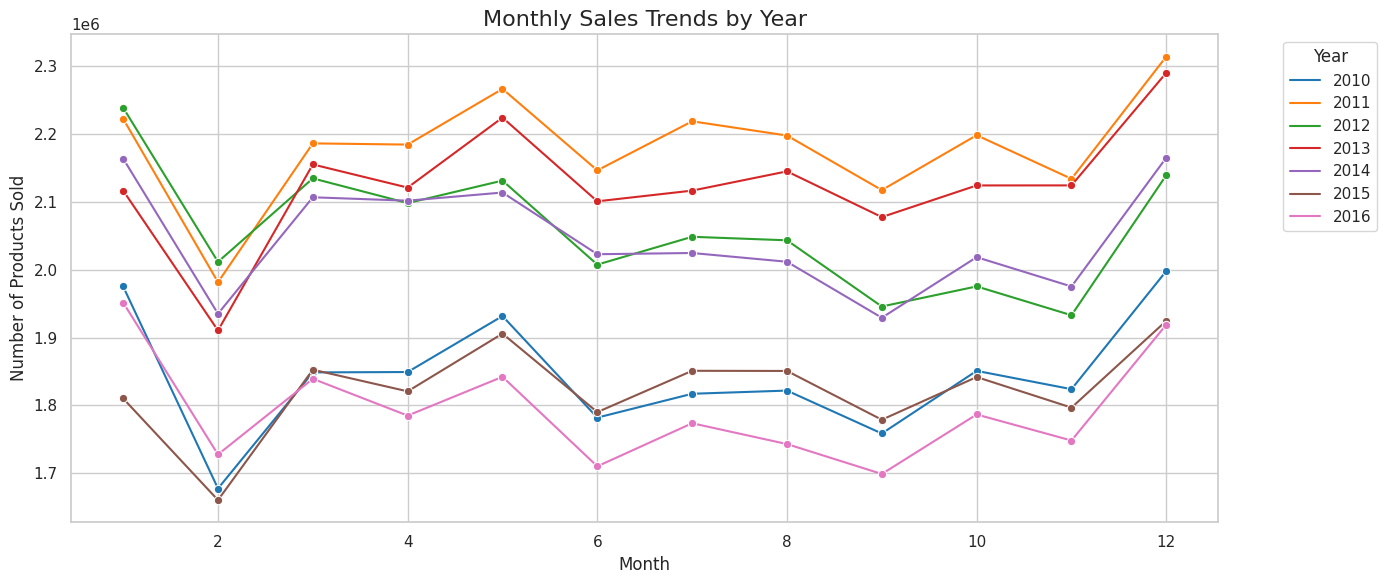

In [18]:
seasonal_sales = train_df.groupby(['year', 'month'])['num_sold'].sum().reset_index()

palette = sns.color_palette("tab10", n_colors=len(seasonal_sales['year'].unique()))

plt.figure(figsize=(14, 6))
sns.lineplot(data=seasonal_sales, x='month', y='num_sold', hue='year', marker="o", palette=palette)
plt.title('Monthly Sales Trends by Year', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Products Sold', fontsize=12)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('monthly.png')  
plt.show()
plt.close()

#### Key Observations:
* Sales tend to peak around the end of the year (likely November/December) and often have a dip at the beginning of the year (January/February). This suggests a strong influence of holiday shopping or end-of-year promotions consistently across all years.
* A dip in sales consistently occurs in February across all years, possibly due to post-holiday spending slowdown or fewer shopping days.

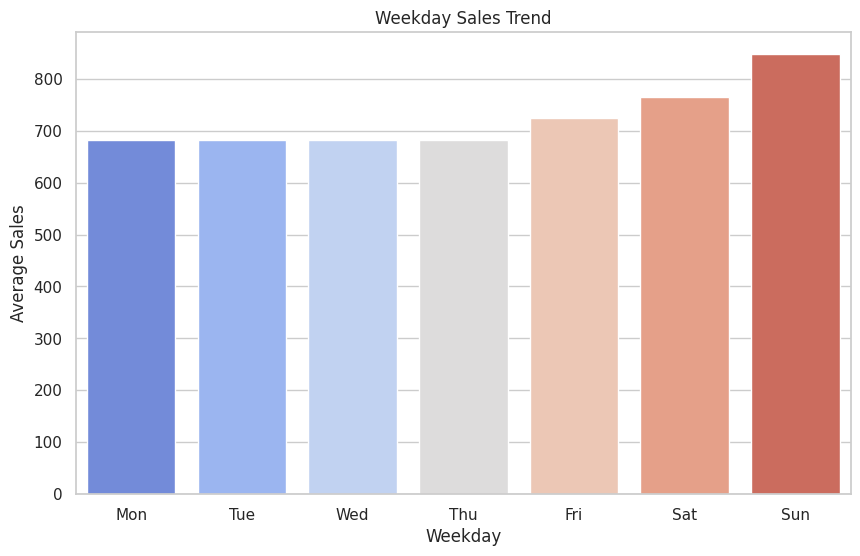

In [20]:
weekday_sales = train_df.groupby('weekday')['num_sold'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=weekday_sales.index, y=weekday_sales.values, palette="coolwarm")
plt.title('Weekday Sales Trend')
plt.xlabel('Weekday')
plt.ylabel('Average Sales')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.savefig('weekly.png')  
plt.show()
plt.close()

#### Key Observations:
* The highest sales occurring on Sunday and a noticeable increase starting on Friday.
* Sales remain consistent and lower throughout the rest of the week.
* Strong weekend effect on sales, with Sunday as the peak.

### Year End Sales

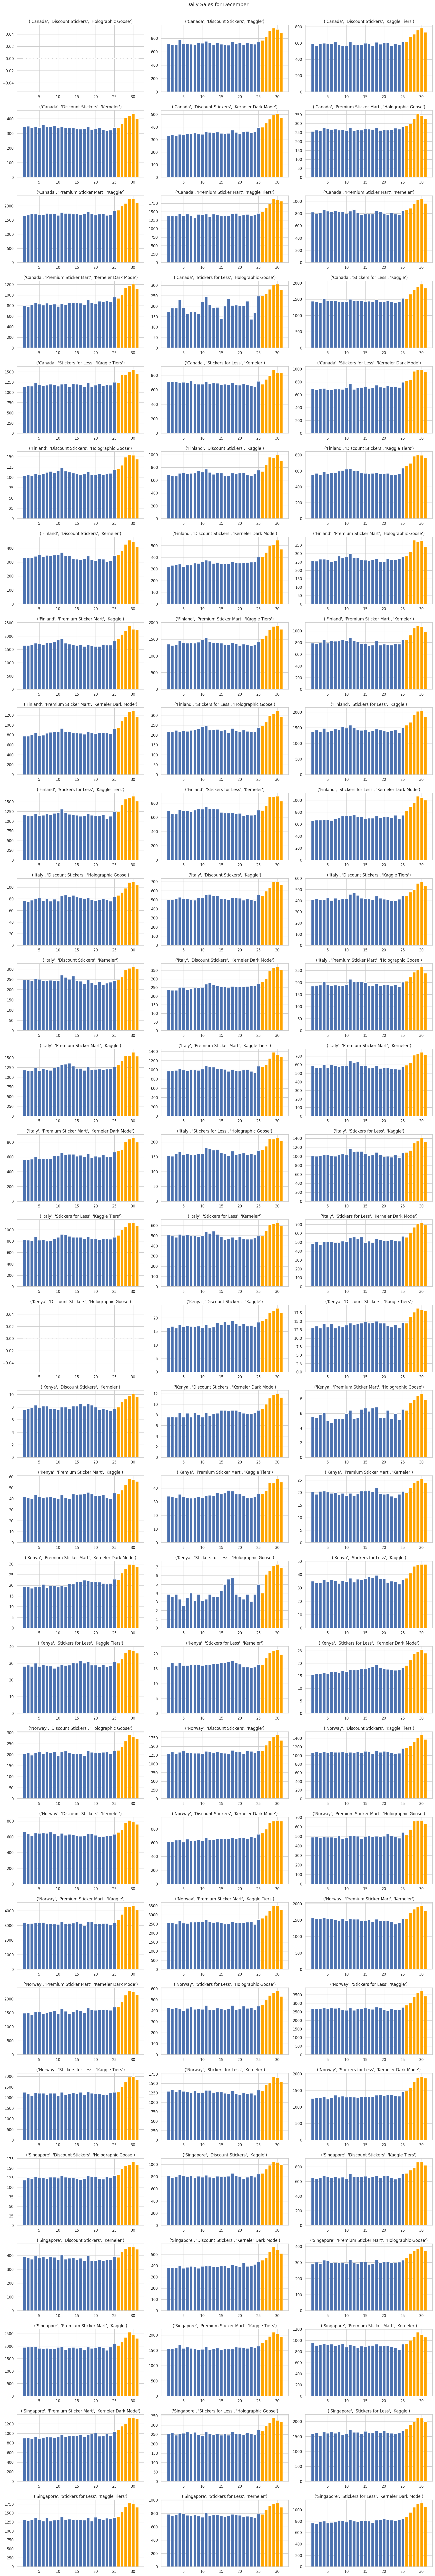

In [21]:
num_groups = 90
cols = 3
rows = math.ceil(num_groups / cols)

plt.figure(figsize=(18, rows * 3.5))

for i, (combi, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(rows, cols, i + 1)

    december_sales = (
        df[df['date'].dt.month == 12]
        .groupby(df['date'].dt.day)['num_sold']
        .mean()
    )

    ax.bar(
        december_sales.index,
        december_sales,
        color=['b'] * 25 + ['orange'] * 6    )

    ax.set_title(combi)
    ax.set_xticks(ticks=range(5, 31, 5))

plt.tight_layout(h_pad=1.5)
plt.suptitle('Daily Sales for December', y=1.005)
plt.savefig('december.png')  
plt.show()
plt.close()

#### Key Observations:
* Show a noticeable spike in sales towards the end of December (indicated by the orange bars). This suggests a strong end-of-year sales push or holiday shopping effect.